CB Analysis

Update
* 為加強"動態因子"維度對於模型的影響力，動態因子調整為客戶有任一命中，動態因子維度即為最大值(1)。

In [1]:
import os.path
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve #P-R Curve
from sklearn import metrics
from sklearn.model_selection import GridSearchCV #Hyperparameters

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import preprocessing

#### 1. Data Import & Cleaning

In [2]:
CB = pd.read_csv(r"/home/bigdata93601/DB Result/DW_AMLCRR_RMA_JOIN_20200801.csv", dtype=str)


##### Drop Duplicated data (New Version)
目的: 僅保留在資訊層面最新之帳戶

In [ ]:
# 僅保留客戶最新資訊欄位
use_cols = ['CUST_ID', 'CUST_DUP_NO']
CB = CB.sort_values('CYC_MN', ascending=False).drop_duplicates(subset=use_cols, keep='first')
CB.reset_index(inplace=True)

#### 2. 變數轉換

##### A. 地域風險

In [3]:
# EY補充
# 新增欄位的情況下，將變數轉換為1/3/5的資料格式。
# 使用者需要自行定義分數轉換條件
# 下面範例將以df代表輸入資料，NEW_COLUMN代表新增欄位
# 
# 範例一
# 新增欄位的資料內容為["V", Nan, "V", "V", Nan, ... , "V"]
# 使用者定義將V轉換為5，空值(Nan)轉換為1。
# df["NEW_COLUMN"] = np.where(df["NEW_COLUMN"] == "V", "5", "1")


# GEOGRAPHY_SCORE
def GEOGRAPHY_SCORE_TRANSFORM(series):
    input = series
    if input == '+001.00':
        return '1'
    elif input == '+050.00':
        return '3'
    else:
        return '5'

CB['NATION_RISK'] = CB['GEOGRAPHY_SCORE'].apply(GEOGRAPHY_SCORE_TRANSFORM).astype(int)


# CMFCUS25_AE_TYPE
CB['CMFCUS25_AE_TYPE'] = np.where((CB["CMFCUS25_AE_TYPE"].isin(['1', '2', '3', '4', '5', '6', '7'])), '5', '1').astype(int)

# CMFCUS25_CHINA_FLAG
CB['CMFCUS25_CHINA_FLAG'] = CB['CMFCUS25_CHINA_FLAG'].map({'2': '5', '1': '3'}).fillna('0').astype(int)


# 新增REGION_RISK(為地域風險的加總分數)
CB['REGION_RISK'] = CB['NATION_RISK'] + CB['CMFCUS25_AE_TYPE'] + CB['CMFCUS25_CHINA_FLAG']


##### B. 行/職業

In [ ]:
# EY補充
# 下面預先檢視各欄位在通匯業務客戶的分佈，若全部資料皆相同，則該欄位無需進行轉換也無須放入模型

In [4]:
CB['CMFCUS1_TITLE_CODE'].value_counts()

Series([], Name: CMFCUS1_TITLE_CODE, dtype: int64)

In [5]:
# CMFCUS1_BUSINESS_CODE
BUSINESS_CODE_TABLE = pd.read_csv(r"/home/bigdata93601/DB Result/BUSINESS_CODE_TABLE.csv", dtype=str) #行業編號對照風險等級表

# Create dictionary
BUSINESS_CODE_dict = {'L': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='L']['CODE'].tolist(),
                      'M': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='M']['CODE'].tolist(),
                      'H': BUSINESS_CODE_TABLE[BUSINESS_CODE_TABLE['RISK']=='H']['CODE'].tolist()}
# Inverse dictionary
BUSINESS_CODE_dict = {c: r for r, code in BUSINESS_CODE_dict.items() for c in code}

CB['CMFCUS1_BUSINESS_CODE'].replace(BUSINESS_CODE_dict, inplace=True)
# Nan轉為L
CB['CMFCUS1_BUSINESS_CODE'] = np.where(~CB["CMFCUS1_BUSINESS_CODE"].isin(['H', 'M', 'L']), 'L', CB['CMFCUS1_BUSINESS_CODE'])

CB['CMFCUS1_BUSINESS_CODE'] = CB['CMFCUS1_BUSINESS_CODE'].map({'H': '5', 'M': '3', 'L': '1'}).astype(int)


# 'CMFCUS1_BUSINESS_FLAG'
CB['CMFCUS1_BUSINESS_FLAG'] = np.where(~CB['CMFCUS1_BUSINESS_FLAG'].isin(['Y', 'N']), 'N', CB['CMFCUS1_BUSINESS_FLAG'])
CB['CMFCUS1_BUSINESS_FLAG'] = CB['CMFCUS1_BUSINESS_FLAG'].map({'Y': '1', 'N': '5'}).astype(int)

# CORP_TYPE
def apply_CORP_TYPE(series):
    input = series
    if (input in [np.nan]):
        return '5'
    elif (input in ['Z']):
        return '3'
    else:
        return '1'
    
CB['CORP_TYPE'] = CB['CORP_TYPE'].apply(apply_CORP_TYPE).astype(int)

# JOB_RISK
def risk_to_number(series):
    input = series
    if input == 'H':
        return '5'
    elif input == 'M':
        return '3'
    else:
        return '1'
CB['JOB_RISK'] = CB['JOB_RISK'].apply(risk_to_number).astype(int)

# 新增INDUSTRY_RISK(為行職業風險的加總分數)
CB['INDUSTRY_RISK'] = CB['CMFCUS1_BUSINESS_CODE'] + CB['CMFCUS1_BUSINESS_FLAG'] + CB['CORP_TYPE'] + CB['JOB_RISK']


##### C. 通路

In [6]:
# 無通路

##### D. 產品服務

In [ ]:
# EY補充
# 下面預先檢視各欄位在通匯業務客戶的分佈，若全部資料皆相同，則該欄位無需進行轉換也無須放入模型

In [6]:
CB['CMFCUS25_OSU_FLAG'].value_counts()

N    86
Name: CMFCUS25_OSU_FLAG, dtype: int64

In [7]:
# 1. 業務類別
for i in ['DP_FG', 'LN_FG', 'IX_FG', 'BD_FG', 'FD_FG', 'WM_FG', 'TR_FG', 'EB_FG', 'CD_FG', 'OT_FG']:
    CB[i] = np.where(CB[i] == 'V', 1, 0)

# 業務數目加總
CB['BUSINESS_COUNT'] = CB[['DP_FG', 'LN_FG', 'IX_FG', 'BD_FG', 'FD_FG', 'WM_FG', 'TR_FG', 'EB_FG', 'CD_FG', 'OT_FG']].sum(axis='columns')

# 換算為風險分數
def COUNT_TO_NUMBER(series):
    input = series
    if input >= 5:
        return '5'
    elif (input > 1) & (input < 5):
        return '3'
    else:
        return '1'
    
CB['BUSINESS_COUNT'] = CB['BUSINESS_COUNT'].apply(COUNT_TO_NUMBER).astype(int)

# 2. CMFCUS1_DERIVATIVE
CB['CMFCUS1_DERIVATIVE'] = CB['CMFCUS1_DERIVATIVE'].map({'1': '5', '2': '1', '3': '1', '4': '1', '5': '3'}).fillna('1').astype(int)


# 新增PRODUCT_RISK(為產品風險的加總分數)
CB['PRODUCT_RISK'] = CB['BUSINESS_COUNT'] + CB['CMFCUS1_DERIVATIVE']



##### E. 組織型態

In [ ]:
# EY補充
# 下面預先檢視各欄位在通匯業務客戶的分佈，若全部資料皆相同，則該欄位無需進行轉換也無須放入模型

In [11]:
CB['CMFCUS1_PREOFFICE'].value_counts()

N    86
Name: CMFCUS1_PREOFFICE, dtype: int64

In [12]:
CB['CMFCUS1_NPO_TYPE'].value_counts()

Series([], Name: CMFCUS1_NPO_TYPE, dtype: int64)

In [13]:
CB['COMPLEX_CS_FG'].value_counts()

N    86
Name: COMPLEX_CS_FG, dtype: int64

In [14]:
CB['TRUST_HOLDER'].value_counts()

N    86
Name: TRUST_HOLDER, dtype: int64

In [15]:
CB['CMFCUS25_CREATIVE_FLAG'].value_counts()

N    86
Name: CMFCUS25_CREATIVE_FLAG, dtype: int64

In [16]:
CB['CMFCUS25_PUBLIC_CMPY'].value_counts()

Y    56
N    30
Name: CMFCUS25_PUBLIC_CMPY, dtype: int64

In [17]:
CB['ORG_PATTERN'].value_counts()

1    55
2    30
3     1
Name: ORG_PATTERN, dtype: int64

In [18]:
CB['ORG_PATTERN_SCORE'].value_counts()

+001.00    55
+050.00    30
+100.00     1
Name: ORG_PATTERN_SCORE, dtype: int64

In [19]:
# CMFCUS25_PUBLIC_CMPY
CB['CMFCUS25_PUBLIC_CMPY'] = np.where(CB['CMFCUS25_PUBLIC_CMPY'] == 'Y', 1, 5)

# ORG_PATTERN
def ORG_PATTERN_TRANSFORM(series):
    input = series
    if input == '1':
        return '1'
    elif input == '2':
        return '3'
    else:
        return '5'



CB['ORG_PATTERN'] = CB['ORG_PATTERN'].apply(ORG_PATTERN_TRANSFORM).astype(int)

# 新增ORGANIZATION_RISK(為產品風險的加總分數)
CB['ORGANIZATION_RISK'] = CB['CMFCUS25_PUBLIC_CMPY'] + CB['ORG_PATTERN']


##### F.其他

In [20]:
CB['CMFCUS1_OPHONE_CNT'].value_counts()

01    59
02    17
03    10
Name: CMFCUS1_OPHONE_CNT, dtype: int64

In [21]:
CB['CMFCUS1_PURPOSE'].value_counts()

F    67
4    17
8     1
E     1
Name: CMFCUS1_PURPOSE, dtype: int64

In [22]:
CB['CONFIRM_YN'].value_counts()

N    83
Y     3
Name: CONFIRM_YN, dtype: int64

In [23]:
CB['CONFIRM_TYPE'].value_counts()

3    3
Name: CONFIRM_TYPE, dtype: int64

In [24]:
CB['AUTHORIZED'].value_counts()

N    84
Y     2
Name: AUTHORIZED, dtype: int64

In [25]:
CB['CUST_THIRD'].value_counts()

N    86
Name: CUST_THIRD, dtype: int64

In [26]:
CB['CMFCUS25_CERTI_FLAG'].value_counts()

Y    86
Name: CMFCUS25_CERTI_FLAG, dtype: int64

In [27]:
CB['CMFCUS25_TAXFREE_FLAG'].value_counts()

N    86
Name: CMFCUS25_TAXFREE_FLAG, dtype: int64

In [28]:
CB['AUTHORIZED'].value_counts()

N    84
Y     2
Name: AUTHORIZED, dtype: int64

In [29]:
CB['LTNC_FLAG'].value_counts()

N    85
Y     1
Name: LTNC_FLAG, dtype: int64

In [30]:
# CMFCUS1_OPHONE_CNT
def COUNT_TO_NUMBER(series):
    input = series
    if input >= 5:
        return '5'
    elif (input > 2) & (input < 5):
        return '3'
    else:
        return '1'
    
CB['CMFCUS1_OPHONE_CNT'] = CB['CMFCUS1_OPHONE_CNT'].fillna('0').astype(int).apply(COUNT_TO_NUMBER).astype(int)

# CMFCUS1_PURPOSE
def PURPOSE_TO_NUMBER(series):
    input = series
    if input in ['1', '3', '4', '5', '7', '8', 'D', 'E']:
        return '3'
    elif input in ['2', '6', 'B', 'X', 'Z']:
        return '1'
    else:
        return '5'
CB['CMFCUS1_PURPOSE'] = CB['CMFCUS1_PURPOSE'].apply(PURPOSE_TO_NUMBER).astype(int)

# CONFIRM_YN
CB['CONFIRM_YN'] = CB['CONFIRM_YN'].map({'Y': '5', 'N': '1', np.nan: '5'}).astype(int)

# CONFIRM_TYPE
CB['CONFIRM_TYPE'] = np.where(CB['CONFIRM_TYPE'].isin(['1', '2', '3']), 5, 1).astype(int)

# PEP_COUNT_THR_1
test = CB[(CB['PEP_1'] == 'Y') | (CB['PEP_2'] == 'Y') | (CB['PEP_3'] == 'Y') | (CB['PEP_4'] == 'Y')][['PEP_1', 'PEP_2', 'PEP_3', 'PEP_4']]
test2 = test.apply(pd.Series.value_counts, axis=1).fillna(0)
CB['PEP_COUNT'] = 0
CB.loc[test2.index, 'PEP_COUNT'] = test2['Y']

CB['PEP_COUNT_THR_1'] = np.where(CB['PEP_COUNT'] >=1, '5', '1').astype(int)

# AUTHORIZED
CB['AUTHORIZED'] = np.where(CB['AUTHORIZED'] == 'Y', 5, 1)

# LTNC_FLAG
CB['LTNC_FLAG'] = np.where(CB['LTNC_FLAG'] == 'Y', 5, 1)

CB['ELSE'] = CB['CMFCUS1_OPHONE_CNT'] + CB['CMFCUS1_PURPOSE'] + CB['CONFIRM_YN'] + CB['CONFIRM_TYPE'] + CB['PEP_COUNT_THR_1'] + CB['AUTHORIZED'] + CB['LTNC_FLAG']

##### G. Trade

In [ ]:
# EY補充
# 下面預先檢視各欄位在通匯業務客戶的分佈，若全部資料皆相同，則該欄位無需進行轉換也無須放入模型

In [31]:
CB['CB_BETWEEN_SCORE'].value_counts()

1.0    86
Name: CB_BETWEEN_SCORE, dtype: int64

In [32]:
CB['CB_DOMESTIC_SCORE'].value_counts()

50.0    56
0.0     30
Name: CB_DOMESTIC_SCORE, dtype: int64

In [33]:
CB['CB_INTERNATIONAL_SCORE'].value_counts()

0.0      68
100.0    18
Name: CB_INTERNATIONAL_SCORE, dtype: int64

In [34]:
# 資金轉帳

CB['CB_BETWEEN_SCORE'] = np.where(CB['CB_BETWEEN_SCORE'] == '1.0', '5', '1').astype(int)

CB['CB_DOMESTIC_SCORE'] = np.where(CB['CB_DOMESTIC_SCORE'] == '50.0', '5', '1').astype(int)

CB['CB_INTERNATIONAL_SCORE'] = np.where(CB['CB_INTERNATIONAL_SCORE'] == '100.0', '5', '1').astype(int)

CB['TRADE'] = CB['CB_BETWEEN_SCORE'] + CB['CB_DOMESTIC_SCORE'] + CB['CB_INTERNATIONAL_SCORE']

##### H. 動態風險因子

In [35]:
CB['RELATIVE_PEP_SCORE'].value_counts()

+000.00    57
+100.00    29
Name: RELATIVE_PEP_SCORE, dtype: int64

In [36]:
# 使用AML_CRR 1-1 ~ 1-10 SCORE進行轉換
# ALERT_COUNT, LTNC_FLAG
CB['RELATIVE_PEP_SCORE'] = np.where(CB['RELATIVE_PEP_SCORE'] == '+100.00', '5', '1').astype(int)

risk_list = ['CUST_NEG_SCORE', 'RELATIVE_NEG_SCORE', 'BANNED_SCORE', 'BEAR_STOCK_SCORE', 
             'STOCK_SCORE', 'SAR_SCORE', 'SPECIFIC_INDUSTRY_SCORE', 'NESTING_SCORE', 'CO_REFGEO_SCORE']
for col in risk_list:
    CB[col] =CB[col].map({'100.0': '5', '0.0': '1'}).astype(int)


CB['ACTIVE_RISK'] = CB[['RELATIVE_PEP_SCORE', 'CUST_NEG_SCORE', 'RELATIVE_NEG_SCORE', 'BANNED_SCORE', 'BEAR_STOCK_SCORE', 'STOCK_SCORE', 'SAR_SCORE', 'SPECIFIC_INDUSTRY_SCORE', 'NESTING_SCORE', 'CO_REFGEO_SCORE']].sum(axis='columns')

##### I. 名單

In [ ]:
# EY補充
# 下面預先檢視各欄位在通匯業務客戶的分佈，若全部資料皆相同，則該欄位無需進行轉換也無須放入模型

In [37]:
print(CB['CUST_PANA'].value_counts(dropna=False))

print(CB['CUST_BAHA'].value_counts(dropna=False))

print(CB['CUST_PARA'].value_counts(dropna=False))

N    86
Name: CUST_PANA, dtype: int64
N      63
NaN    23
Name: CUST_BAHA, dtype: int64
N      63
NaN    23
Name: CUST_PARA, dtype: int64


In [38]:
print(CB['PANAMA_MARK'].value_counts(dropna=False))

print(CB['BAHAMAS_MARK'].value_counts(dropna=False))

print(CB['PARADISE_MARK'].value_counts(dropna=False))

N    86
Name: PANAMA_MARK, dtype: int64
N      63
NaN    23
Name: BAHAMAS_MARK, dtype: int64
N      63
NaN    23
Name: PARADISE_MARK, dtype: int64


In [37]:
# 名單皆為N

#### 3. 資料正規化
Normalize data to 0 and 1

In [40]:
# EY補充
# 資料的正規化(Normalization)是將原始資料的數據按比例縮放於 [0, 1] 區間中，且不改變其原本分佈
# 該資料轉換，能排除資料單位的限制，提供我們一個相同的基準來進行後續比較分析

min_max_scaler = preprocessing.MinMaxScaler()

CB[['REGION_RISK', 'INDUSTRY_RISK', 'PRODUCT_RISK', 'ORGANIZATION_RISK', 'ELSE', 'TRADE', 'ACTIVE_RISK']] = min_max_scaler.fit_transform(CB[['REGION_RISK', 'INDUSTRY_RISK', 'PRODUCT_RISK', 'ORGANIZATION_RISK', 'ELSE', 'TRADE', 'ACTIVE_RISK']])

In [41]:
# EY補充
# 為強化動態因子對於資料的影響力，將"動態因子"維度修改為客戶命中任何一個則該維度即為1
# 後續若想與其他維度保持相同的評分標準，僅需移除下面程式碼

# 動態因子更動
CB['ACTIVE_RISK_Update'] = np.where(CB['ACTIVE_RISK'] > 0, 1, CB['ACTIVE_RISK'])

#### 4. Outlier Detection

##### 4.1 get 平均值

In [42]:
CB_avg = pd.Series([np.mean(CB['REGION_RISK']), np.mean(CB['INDUSTRY_RISK']), np.mean(CB['PRODUCT_RISK']), np.mean(CB['ORGANIZATION_RISK']), 
                    np.mean(CB['ELSE']), np.mean(CB['TRADE']), np.mean(CB['ACTIVE_RISK']), np.mean(CB['ACTIVE_RISK_Update'])], 
                    index=['REGION_RISK', 'INDUSTRY_RISK', 'PRODUCT_RISK', 'ORGANIZATION_RISK', 
                           'ELSE', 'TRADE', 'ACTIVE_RISK', 'ACTIVE_RISK_Update'])

In [43]:
CB_avg

REGION_RISK           0.151163
INDUSTRY_RISK         0.670543
PRODUCT_RISK          0.750000
ORGANIZATION_RISK     0.356589
ELSE                  0.161130
TRADE                 0.860465
ACTIVE_RISK           0.130814
ACTIVE_RISK_Update    0.383721
dtype: float64

##### 4.2 Calculation

In [44]:
for i in range(86):
    distance = (CB.loc[i, ['REGION_RISK', 'INDUSTRY_RISK', 'PRODUCT_RISK', 'ORGANIZATION_RISK', 'ELSE', 'TRADE', 'ACTIVE_RISK_Update']] - CB_avg[['REGION_RISK', 'INDUSTRY_RISK', 'PRODUCT_RISK', 'ORGANIZATION_RISK', 'ELSE', 'TRADE', 'ACTIVE_RISK_Update']]).sum()
    CB.loc[i, 'distance'] = distance

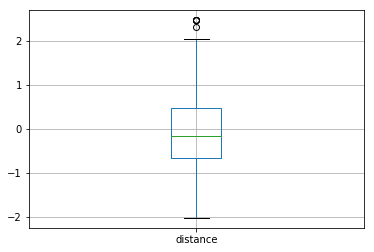

In [45]:
CB.boxplot(column='distance') #Boxplot劃分為參考

In [46]:
# EY補充
# 門檻標準請參考兆豐銀_CRR_第二階段模型開發報告

# 設定門檻

IQR = np.percentile(CB['distance'], 75) - np.percentile(CB['distance'], 25)
threshold = np.percentile(CB['distance'], 75) + 1.5 * IQR

In [47]:
# 計算PHASE_2分類風險
CB['PHASE_2'] = 'C'
CB.loc[CB['distance'] > (math.floor(np.percentile(CB['distance'], 75) * 100) / 100), 'PHASE_2'] = 'B'
CB.loc[CB['distance'] > threshold, 'PHASE_2'] = 'A'

In [48]:
CB['PHASE_2'].value_counts(dropna=False)

C    54
B    22
A    10
Name: PHASE_2, dtype: int64

##### 4.3 Output Data

In [49]:
test = CB[['PHASE_2', 'distance', 'FINAL_CRR', 'SAR', 'REGION_RISK', 'INDUSTRY_RISK', 'PRODUCT_RISK', 'ORGANIZATION_RISK', 'ELSE', 'TRADE', 'ACTIVE_RISK']]

In [50]:
test.head()

,PHASE_2,distance,FINAL_CRR,SAR,REGION_RISK,INDUSTRY_RISK,PRODUCT_RISK,ORGANIZATION_RISK,ELSE,TRADE,ACTIVE_RISK
0,C,-1.524086,L,N,0.0,0.666667,0.0,0.0,0.142857,1.0,0.0
1,C,-1.024086,M,N,0.5,0.666667,0.0,0.0,0.142857,1.0,0.0
2,C,-1.666944,L,N,0.0,0.666667,0.0,0.0,0.000000,1.0,0.0
3,C,-0.666944,M,N,0.5,0.666667,0.5,0.0,0.000000,1.0,0.0
4,C,-0.166944,M,N,1.0,0.666667,0.5,0.0,0.000000,1.0,0.0
